---
title: 11 - XGBoost vs scANVI
author: Martin Proks, Nazmus Salehin
date: 17-01-2024
---

In this notebook we compare the accuracy between XGBoost and scANVI

In [1]:
!which pip

/projects/dan1/data/Brickman/conda/envs/scvi-1.0.0/bin/pip


In [2]:
%matplotlib inline

import scvi
import xgboost as xgb
import pandas as pd
import numpy as np
import seaborn as sns
import scanpy as sc
from tqdm import tqdm
import matplotlib.pyplot as plt

from typing import Tuple

from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
import warnings

warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)
warnings.simplefilter('ignore', category=FutureWarning)
warnings.simplefilter('ignore', category=UserWarning)

scvi.settings.seed = 0

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

/projects/dan1/data/Brickman/conda/envs/scvi-1.0.0/lib/python3.10/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/projects/dan1/data/Brickman/conda/envs/scvi-1.0.0/lib/python3.10/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (
[rank: 0] Global seed set to 0


In [3]:
import anndata
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score


def cripple_classifiers(adata: anndata.AnnData, lvae: scvi.model.SCANVI, xgb_clf: xgb.XGBClassifier, groupby: str):
    """
    To prove a point that scANVI is better in term of prediction compared to XGBoost
    due to it's ability to use full list of HVGs, we sort features (genes) based on
    their normalized dispertion and remove them during prediction.
    We expect that if they are not present the XGBoost performance double downs on its
    performance as it will be missing these features to make a correct prediction.
    """

    denoised = lvae.get_normalized_expression(return_mean=True)
    features = adata.var.sort_values(by='dispersions_norm', ascending=False).index

    metrics = {
        'scANVI': { m: [] for m in ['accuracy', 'balanced', 'f1_micro', 'f1_macro'] },
        'XGBoost': { m: [] for m in ['accuracy', 'balanced', 'f1_micro', 'f1_macro'] }
    }
    
    for i in tqdm([0, 10, 20, 50, 100, 200, 500]):
        less_features = features[i:]

        # XGBoost prediction
        xgb_denoised = denoised.copy()
        if i != 0:
            xgb_denoised.loc[:, less_features] = 0
        xgb_pred = xgb_clf.predict(xgb_denoised)
        
        # scANVI query
        subset = adata[:, less_features].copy()
        subset.obs = subset.obs[['batch']].copy()
        scvi.model.SCANVI.prepare_query_anndata(subset, lvae)
        lvae_q = scvi.model.SCANVI.load_query_data(subset, lvae)
        lvae_q.train(max_epochs=100, plan_kwargs=dict(weight_decay=0.0), check_val_every_n_epoch=10, enable_progress_bar=False)
        scANVI_pred = lvae_q.predict()

        metrics['scANVI']['accuracy'].append(accuracy_score(adata.obs[groupby], scANVI_pred))
        metrics['XGBoost']['accuracy'].append(accuracy_score(adata.obs[groupby].cat.codes.values, xgb_pred))
        
        metrics['scANVI']['balanced'].append(balanced_accuracy_score(adata.obs[groupby], scANVI_pred))
        metrics['XGBoost']['balanced'].append(balanced_accuracy_score(adata.obs[groupby].cat.codes.values, xgb_pred))

        metrics['scANVI']['f1_micro'].append(f1_score(adata.obs[groupby], scANVI_pred, average="micro"))
        metrics['XGBoost']['f1_micro'].append(f1_score(adata.obs[groupby].cat.codes.values, xgb_pred, average="micro"))

        metrics['scANVI']['f1_macro'].append(f1_score(adata.obs[groupby], scANVI_pred, average="macro"))
        metrics['XGBoost']['f1_macro'].append(f1_score(adata.obs[groupby].cat.codes.values, xgb_pred, average="macro"))
    
    return metrics

## Mouse

In [4]:
# base dataset
mouse = sc.read("../results/02_mouse_integration/scanvi_ns_15/adata.h5ad")

# XGBoost
mouse_xg_scVI = xgb.XGBClassifier()
mouse_xg_scVI.load_model("../results/02_mouse_integration/05_scVI_xgboost.json")

# scANVI
mouse_scANVI = scvi.model.SCANVI.load("../results/02_mouse_integration/scanvi_ns_15/")

INFO     File ../results/02_mouse_integration/scanvi_ns_15/model.pt already downloaded                             


In [5]:
mouse_stats = cripple_classifiers(mouse, mouse_scANVI, mouse_xg_scVI, groupby='ct')

  0%|                                                                                                              | 0/7 [00:00<?, ?it/s]

INFO     Found 100.0% reference vars in query data.                                                                
INFO     Training for 100 epochs.                                                                                  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
`Trainer.fit` stopped: `max_epochs=100` reached.
 14%|██████████████▌                                                                                       | 1/7 [00:19<01:57, 19.50s/it]

INFO     Found 99.66666666666667% reference vars in query data.                                                    
INFO     Training for 100 epochs.                                                                                  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
`Trainer.fit` stopped: `max_epochs=100` reached.
 29%|█████████████████████████████▏                                                                        | 2/7 [00:39<01:37, 19.59s/it]

INFO     Found 99.33333333333333% reference vars in query data.                                                    
INFO     Training for 100 epochs.                                                                                  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
`Trainer.fit` stopped: `max_epochs=100` reached.
 43%|███████████████████████████████████████████▋                                                          | 3/7 [00:59<01:19, 19.78s/it]

INFO     Found 98.33333333333333% reference vars in query data.                                                    
INFO     Training for 100 epochs.                                                                                  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
`Trainer.fit` stopped: `max_epochs=100` reached.
 57%|██████████████████████████████████████████████████████████▎                                           | 4/7 [01:19<00:59, 19.93s/it]

INFO     Found 96.66666666666667% reference vars in query data.                                                    
INFO     Training for 100 epochs.                                                                                  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
`Trainer.fit` stopped: `max_epochs=100` reached.
 71%|████████████████████████████████████████████████████████████████████████▊                             | 5/7 [01:39<00:39, 19.85s/it]

INFO     Found 93.33333333333333% reference vars in query data.                                                    
INFO     Training for 100 epochs.                                                                                  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
`Trainer.fit` stopped: `max_epochs=100` reached.
 86%|███████████████████████████████████████████████████████████████████████████████████████▍              | 6/7 [01:58<00:19, 19.85s/it]

INFO     Found 83.33333333333334% reference vars in query data.                                                    
INFO     Training for 100 epochs.                                                                                  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
`Trainer.fit` stopped: `max_epochs=100` reached.
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:19<00:00, 19.90s/it]


## Human

### XGBoost [scANVI]

In [7]:
%run ../scripts/helpers.py

In [8]:
# base dataset
human = sc.read("../results/02_human_integration/05_scanvi_ns15/adata.h5ad")

INFO     File ../results/02_human_integration/scvi/model.pt already downloaded                                     
[0]	validation_0-merror:0.06048	validation_0-mlogloss:1.25520	validation_1-merror:0.22081	validation_1-mlogloss:1.52118
[1]	validation_0-merror:0.03240	validation_0-mlogloss:0.89775	validation_1-merror:0.18471	validation_1-mlogloss:1.22860
[2]	validation_0-merror:0.01674	validation_0-mlogloss:0.66799	validation_1-merror:0.18471	validation_1-mlogloss:1.04108
[3]	validation_0-merror:0.01242	validation_0-mlogloss:0.50784	validation_1-merror:0.16985	validation_1-mlogloss:0.89968
[4]	validation_0-merror:0.00756	validation_0-mlogloss:0.39042	validation_1-merror:0.16561	validation_1-mlogloss:0.79915
[5]	validation_0-merror:0.00486	validation_0-mlogloss:0.30346	validation_1-merror:0.16348	validation_1-mlogloss:0.71425
[6]	validation_0-merror:0.00162	validation_0-mlogloss:0.23622	validation_1-merror:0.15711	validation_1-mlogloss:0.64952
[7]	validation_0-merror:0.00108	validation_0

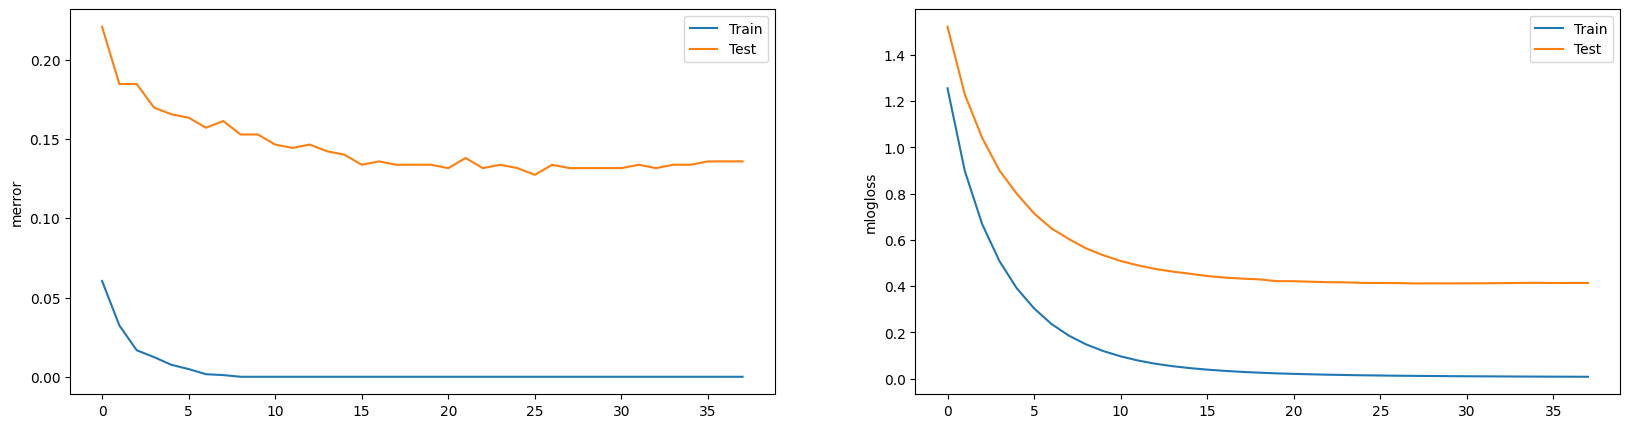

In [9]:
vae = scvi.model.SCVI.load("../results/02_human_integration/scvi/")
vae_df = pd.DataFrame(vae.get_normalized_expression(return_mean=True))
vae_df['target'] = human.obs.C_scANVI_nsamples

X_train, y_train, X_test, y_test = train_test_split_by_group(vae_df)
vae_xgboost = train_xgboost(vae_df, X_train, y_train, X_test, y_test)
vae_xgboost.save_model("../results/02_human_integration/11_scVI_xgboost.json")

### Comparison

In [10]:
# XGBoost
human_xg_scVI = xgb.XGBClassifier()
human_xg_scVI.load_model("../results/02_human_integration/11_scVI_xgboost.json")

# scANVI
human_scANVI = scvi.model.SCANVI.load("../results/02_human_integration/05_scanvi_ns15/")

INFO     File ../results/02_human_integration/05_scanvi_ns15/model.pt already downloaded                           


In [11]:
human_stats = cripple_classifiers(human, human_scANVI, human_xg_scVI, groupby='C_scANVI_nsamples')

  0%|                                                                                                              | 0/7 [00:00<?, ?it/s]

INFO     Found 100.0% reference vars in query data.                                                                
INFO     Training for 100 epochs.                                                                                  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
`Trainer.fit` stopped: `max_epochs=100` reached.
 14%|██████████████▌                                                                                       | 1/7 [00:22<02:13, 22.20s/it]

INFO     Found 99.66666666666667% reference vars in query data.                                                    
INFO     Training for 100 epochs.                                                                                  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
`Trainer.fit` stopped: `max_epochs=100` reached.
 29%|█████████████████████████████▏                                                                        | 2/7 [00:46<01:56, 23.34s/it]

INFO     Found 99.33333333333333% reference vars in query data.                                                    
INFO     Training for 100 epochs.                                                                                  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
`Trainer.fit` stopped: `max_epochs=100` reached.
 43%|███████████████████████████████████████████▋                                                          | 3/7 [01:10<01:34, 23.63s/it]

INFO     Found 98.33333333333333% reference vars in query data.                                                    
INFO     Training for 100 epochs.                                                                                  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
`Trainer.fit` stopped: `max_epochs=100` reached.
 57%|██████████████████████████████████████████████████████████▎                                           | 4/7 [01:33<01:10, 23.61s/it]

INFO     Found 96.66666666666667% reference vars in query data.                                                    
INFO     Training for 100 epochs.                                                                                  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
`Trainer.fit` stopped: `max_epochs=100` reached.
 71%|████████████████████████████████████████████████████████████████████████▊                             | 5/7 [01:57<00:47, 23.62s/it]

INFO     Found 93.33333333333333% reference vars in query data.                                                    
INFO     Training for 100 epochs.                                                                                  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
`Trainer.fit` stopped: `max_epochs=100` reached.
 86%|███████████████████████████████████████████████████████████████████████████████████████▍              | 6/7 [02:21<00:23, 23.77s/it]

INFO     Found 83.33333333333334% reference vars in query data.                                                    
INFO     Training for 100 epochs.                                                                                  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
`Trainer.fit` stopped: `max_epochs=100` reached.
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:44<00:00, 23.53s/it]


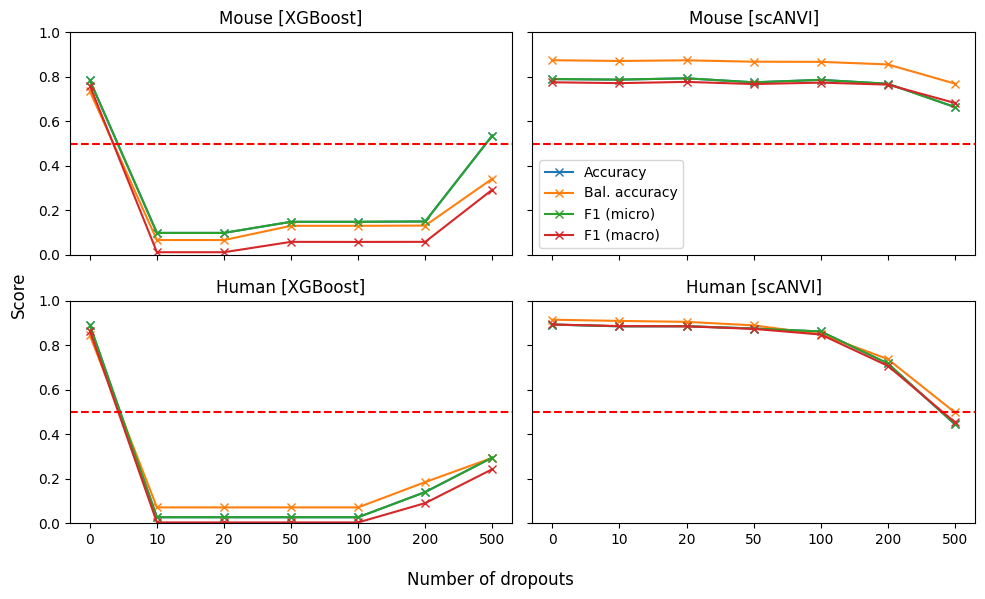

In [122]:
fig, ax = plt.subplots(2, 2, figsize=[10, 6], sharey=True, sharex=True)

pd.DataFrame.from_dict(mouse_stats['XGBoost']).plot.line(marker='x', ylim=(0,1), title='Mouse [XGBoost]', legend=None, ax=ax[0, 0])
pd.DataFrame.from_dict(mouse_stats['scANVI']).plot.line(marker='x', ylim=(0,1), title='Mouse [scANVI]', legend=None, ax=ax[0, 1])
pd.DataFrame.from_dict(human_stats['XGBoost']).plot.line(marker='x', ylim=(0,1), title='Human [XGBoost]', legend=None, ax=ax[1, 0])
pd.DataFrame.from_dict(human_stats['scANVI']).plot.line(marker='x', ylim=(0,1), title='Human [scANVI]', legend=None, ax=ax[1, 1])

for i in range(2):
    ax[1, i].set_xticklabels(['', '0', '10', '20', '50', '100', '200', '500'])
    ax[0, i].axhline(0.5, c='r', ls='--')
    ax[1, i].axhline(0.5, c='r', ls='--')

ax[0, 1].legend(('Accuracy','Bal. accuracy', 'F1 (micro)', 'F1 (macro)'))

fig.supxlabel('Number of dropouts')
fig.supylabel('Score')
fig.tight_layout()
fig.savefig('../figures/xgboost_vs_scanvi_v1.svg')

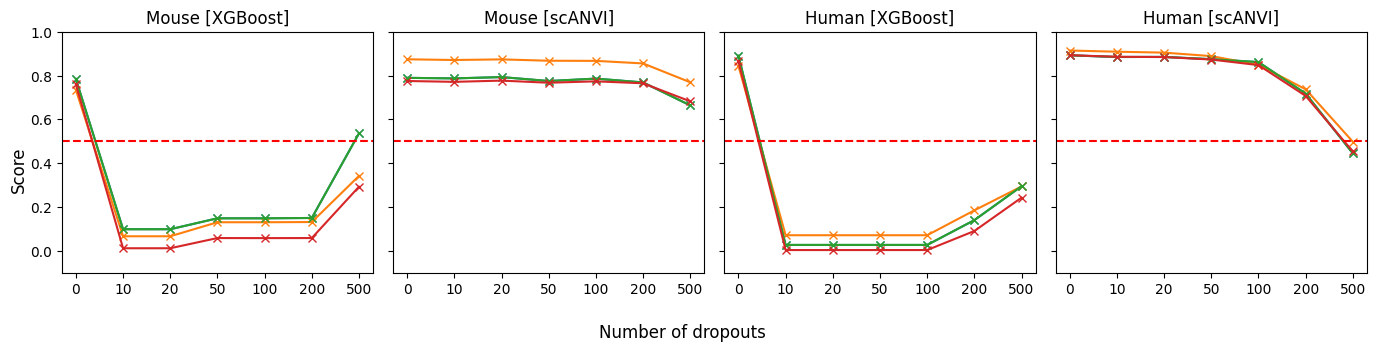

In [129]:
fig, ax = plt.subplots(1, 4, figsize=[14, 3.5], sharey=True, sharex=True)

pd.DataFrame.from_dict(mouse_stats['XGBoost']).plot.line(marker='x', ylim=(-0.1,1), title='Mouse [XGBoost]', legend=None, ax=ax[0])
pd.DataFrame.from_dict(mouse_stats['scANVI']).plot.line(marker='x', ylim=(-0.1,1), title='Mouse [scANVI]', legend=None, ax=ax[1])
pd.DataFrame.from_dict(human_stats['XGBoost']).plot.line(marker='x', ylim=(-0.1,1), title='Human [XGBoost]', legend=None, ax=ax[2])
pd.DataFrame.from_dict(human_stats['scANVI']).plot.line(marker='x', ylim=(-0.1,1), title='Human [scANVI]', legend=None, ax=ax[3])

for i in range(4):
    ax[i].set_xticklabels(['', '0', '10', '20', '50', '100', '200', '500'])
    ax[i].axhline(0.5, c='r', ls='--')

# ax[3].legend(('Accuracy','Bal. accuracy', 'F1 (micro)', 'F1 (macro)'), ncol=4)

fig.supxlabel('Number of dropouts')
fig.supylabel('Score')
fig.tight_layout()
fig.savefig('../figures/xgboost_vs_scanvi_v2.svg')

In [141]:
pd.concat([
    pd.DataFrame.from_dict(mouse_stats['XGBoost']).assign(clf = 'XGBoost').assign(species = 'mouse'),
    pd.DataFrame.from_dict(mouse_stats['scANVI']).assign(clf = 'scANVI').assign(species = 'mouse'),
    pd.DataFrame.from_dict(human_stats['XGBoost']).assign(clf = 'XGBoost').assign(species = 'human'),
    pd.DataFrame.from_dict(human_stats['scANVI']).assign(clf = 'scANVI').assign(species = 'human')
]).to_excel('../results/suppl-tab-3.xlsx')